In [3]:
from deep_frecker import DeepFrecker, FreckerDataSet
from torch.utils.data import DataLoader, random_split
import torch
import torch.optim as optim
import torch.nn.functional as F
from fnet import MaskLoss, Conv3DStack


In [2]:

# HDF5文件路径和数据集名称
file_path = r"C:\Users\lucyc\Desktop\freckers_data\base_v1.h5"

# 创建H5Dataset对象
dataset = FreckerDataSet(file_path)

# 定义训练集和验证集的大小
train_size = int(0.8 * len(dataset))  # 80% 用于训练
val_size = len(dataset) - train_size  # 20% 用于验证

# 使用 random_split 分割数据集
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 64
shuffle = True
num_workers = 2

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, persistent_workers=True)


In [4]:
model = Conv3DStack()

In [4]:
num_epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
mask_loss = MaskLoss()

train_loss_record = []
eval_loss_record = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for gameboard, action_prob, value in train_loader:
        gameboard = gameboard.to(device)
        action_prob = action_prob.to(device)
        value = value.to(device)

        optimizer.zero_grad()
        p_action_prob, p_value = model(gameboard)
        # 计算双损失
        loss_img = mask_loss(p_action_prob, action_prob)
        loss_prob = F.mse_loss(p_value.view(-1), value)
        total_loss = loss_img + loss_prob
        
        total_loss.backward()
        optimizer.step()
        train_loss += total_loss.item()
    
    train_loss /= len(train_loader)
    train_loss_record.append(train_loss)

    model.eval()
    eval_loss = 0.0
    with torch.no_grad():
        for gameboard, action_prob, value in val_loader:
            gameboard = gameboard.to(device)
            action_prob = action_prob.to(device)
            value = value.to(device)

            p_action_prob, p_value = model(gameboard)
            loss_img = mask_loss(p_action_prob, action_prob)
            loss_prob = F.mse_loss(p_value.view(-1), value)
            total_loss = loss_img + loss_prob
            
            eval_loss += total_loss.item()
    
    eval_loss /= len(val_loader)
    eval_loss_record.append(eval_loss)

    print(f"Epoch {epoch+1}, Training Loss: {train_loss:.8f}, Validation Loss: {eval_loss:.8f}")



Epoch 1, Training Loss: 0.69997435, Validation Loss: 0.52306775
Epoch 2, Training Loss: 0.53616394, Validation Loss: 0.52276975
Epoch 3, Training Loss: 0.53805697, Validation Loss: 0.53860060
Epoch 4, Training Loss: 0.53610163, Validation Loss: 0.52055916
Epoch 5, Training Loss: 0.53217123, Validation Loss: 0.52250887
Epoch 6, Training Loss: 0.53324445, Validation Loss: 0.52058337
Epoch 7, Training Loss: 0.53291260, Validation Loss: 0.51914750
Epoch 8, Training Loss: 0.53072120, Validation Loss: 0.51925204
Epoch 9, Training Loss: 0.53219611, Validation Loss: 0.51849943
Epoch 10, Training Loss: 0.27594540, Validation Loss: 0.02665215
Epoch 11, Training Loss: 0.02623720, Validation Loss: 0.02453208
Epoch 12, Training Loss: 0.02494224, Validation Loss: 0.02434313
Epoch 13, Training Loss: 0.02589407, Validation Loss: 0.03119458
Epoch 14, Training Loss: 0.02537299, Validation Loss: 0.02465951
Epoch 15, Training Loss: 0.02471054, Validation Loss: 0.02724891
Epoch 16, Training Loss: 0.0253855

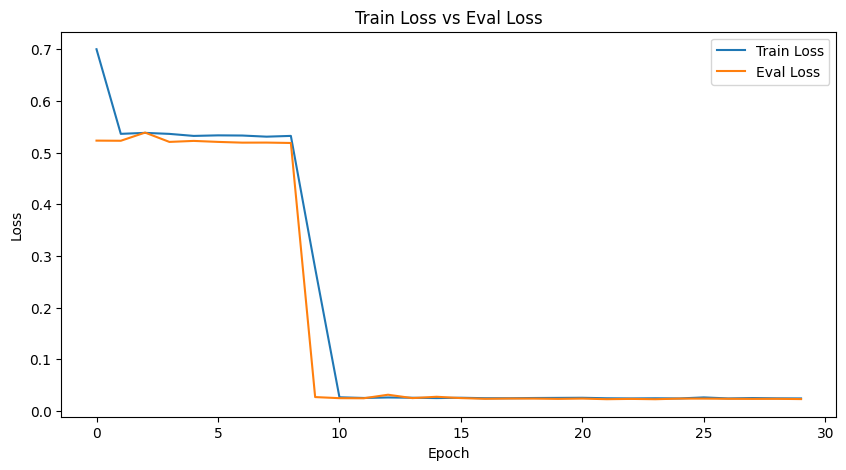

In [5]:
import matplotlib.pyplot as plt

# 绘制训练损失和验证损失的对比图
plt.figure(figsize=(10, 5))
plt.plot(train_loss_record, label='Train Loss')
plt.plot(eval_loss_record, label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss vs Eval Loss')
plt.legend()
plt.show()


In [ ]:
import threading
import time
from mcts import mcts_data_collect

#(model, thread_num, file, rounds=100, sim_step=300)
# 创建多个线程
threads = []
for i in range(8):
    thread = threading.Thread(target=mcts_data_collect, 
            args=(model, i+1, f"C:\\Users\\lucyc\\Desktop\\freckers_data\\batch_1.h5", 30, 500))
    threads.append(thread)
    thread.start()

# 等待所有线程完成
for thread in threads:
    thread.join()
